In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2 
from skimage.morphology import skeletonize



In [21]:
# image = cv2.imread('/Users/agerasymchuk/private_repo/cv_claude_course/cv_course/images/IMG_1814_darker.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('/Users/agerasymchuk/private_repo/cv_claude_course/cv_course/images/human_face.png', cv2.IMREAD_GRAYSCALE)


_, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)



In [91]:
def visualize_morphology(img, operation_name, result):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original')

    ax2.imshow(result, cmap='gray')
    ax2.set_title(f'Result after operation - {operation_name}')

    ax3.imshow(255 - (img - result), cmap='gray',)  # show difference
    ax3.set_title('Difference what changed')
    plt.show()

def add_salt_and_pepper_noise(img, salt_prob=0.02, pepper_prob=0.02):
    noisy = img.copy()
    rnd = np.random.rand(*img.shape)
    noisy[rnd < salt_prob] = 255
    noisy[rnd > 1 - pepper_prob] = 0
    return noisy

def analyze_connectivity(skeleton):
    """
    Analyze the connectivity structure of the skeleton.
    
    This provides useful information like:
    - Number of separate objects/networks
    - Branch points (where paths split)
    - Endpoints (where paths terminate)
    
    Parameters:
    -----------
    skeleton : ndarray
        Binary skeleton image
    
    Returns:
    --------
    analysis : dict
        Dictionary containing connectivity metrics
    labeled : ndarray
        Image with each connected component labeled
    """
    # Convert to uint8 for OpenCV functions
    skeleton_uint8 = (skeleton * 255).astype(np.uint8)
    
    # Find connected components
    num_labels, labeled = cv2.connectedComponents(skeleton_uint8)
    
    # Count total skeleton pixels
    total_skeleton_pixels = np.sum(skeleton)
    
    # Find branch points and endpoints
    # A branch point has 3+ neighbors, an endpoint has 1 neighbor
    branch_points = find_branch_points(skeleton)
    endpoints = find_endpoints(skeleton)
    
    analysis = {
        'num_components': num_labels - 1,  # Subtract 1 for background
        'total_pixels': int(total_skeleton_pixels),
        'num_branches': len(branch_points),
        'num_endpoints': len(endpoints),
        'branch_points': branch_points,
        'endpoints': endpoints
    }
    
    return analysis, labeled

def find_branch_points(skeleton):
    """
    Find branch points in skeleton (pixels with 3+ neighbors).
    These are locations where paths split.
    """
    # Create 3x3 kernel to count neighbors
    kernel = np.ones((3, 3), dtype=np.uint8)
    kernel[1, 1] = 0  # Don't count center pixel
    
    # Count neighbors for each skeleton pixel
    skeleton_uint8 = skeleton.astype(np.uint8)
    neighbor_count = cv2.filter2D(skeleton_uint8, -1, kernel)
    
    # Branch points have 3+ neighbors
    branch_points = np.argwhere((neighbor_count >= 3) & (skeleton > 0))
    
    return branch_points

def find_endpoints(skeleton):
    """
    Find endpoints in skeleton (pixels with exactly 1 neighbor).
    These are locations where paths terminate.
    """
    # Create 3x3 kernel to count neighbors
    kernel = np.ones((3, 3), dtype=np.uint8)
    kernel[1, 1] = 0
    
    # Count neighbors
    skeleton_uint8 = skeleton.astype(np.uint8)
    neighbor_count = cv2.filter2D(skeleton_uint8, -1, kernel)
    
    # Endpoints have exactly 1 neighbor
    endpoints = np.argwhere((neighbor_count == 1) & (skeleton > 0))
    
    return endpoints

def visualize_results(original, separated, eroded, skeleton, analysis, labeled):
    """
    Create comprehensive visualization of all processing steps.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Morphological Separation and Skeletonization Pipeline', 
                 fontsize=16, fontweight='bold')
    
    # 1. Original image with touching objects
    axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title('1. Original (Touching Objects)', fontsize=12)
    axes[0, 0].axis('off')
    
    # 2. After erosion (intermediate step)
    axes[0, 1].imshow(eroded, cmap='gray')
    axes[0, 1].set_title('2. After Erosion\n(Connections broken)', fontsize=12)
    axes[0, 1].axis('off')
    
    # 3. After opening (separated objects)
    axes[0, 2].imshow(separated, cmap='gray')
    axes[0, 2].set_title('3. After Opening\n(Objects separated)', fontsize=12)
    axes[0, 2].axis('off')
    
    # 4. Skeleton overlay on original
    skeleton_overlay = cv2.cvtColor(separated, cv2.COLOR_GRAY2RGB)
    skeleton_overlay[skeleton > 0] = [255, 0, 0]  # Red skeleton
    axes[1, 0].imshow(skeleton_overlay)
    axes[1, 0].set_title('4. Skeleton Overlay', fontsize=12)
    axes[1, 0].axis('off')
    
    # 5. Skeleton with branch points and endpoints
    skeleton_analysis = cv2.cvtColor((skeleton * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    # Mark branch points in green
    for point in analysis['branch_points']:
        cv2.circle(skeleton_analysis, (point[1], point[0]), 3, (0, 255, 0), -1)
    # Mark endpoints in blue
    for point in analysis['endpoints']:
        cv2.circle(skeleton_analysis, (point[1], point[0]), 3, (255, 0, 0), -1)
    
    axes[1, 1].imshow(skeleton_analysis)
    axes[1, 1].set_title('5. Skeleton Analysis\n🟢 Branches | 🔵 Endpoints', fontsize=12)
    axes[1, 1].axis('off')
    
    # 6. Connected components (each component in different color)
    axes[1, 2].imshow(labeled, cmap='nipy_spectral')
    axes[1, 2].set_title('6. Connected Components', fontsize=12)
    axes[1, 2].axis('off')
    
    # Add text summary of analysis
    summary_text = f"""
    CONNECTIVITY ANALYSIS
    ━━━━━━━━━━━━━━━━━━━━
    Connected Components: {analysis['num_components']}
    Total Skeleton Pixels: {analysis['total_pixels']}
    Branch Points: {analysis['num_branches']}
    Endpoints: {analysis['num_endpoints']}
    
    INTERPRETATION
    ━━━━━━━━━━━━━━━━━━━━
    • Each component = separate object/network
    • Branch points = where paths split
    • Endpoints = where paths terminate
    • High branching = complex structure
    """
    
    fig.text(0.02, 0.02, summary_text, fontsize=10, family='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout(rect=[0, 0.12, 1, 0.96])
    plt.savefig('/home/claude/skeleton_analysis_results.png', dpi=150, bbox_inches='tight')
    print("✓ Visualization saved to: skeleton_analysis_results.png")
    
    return fig

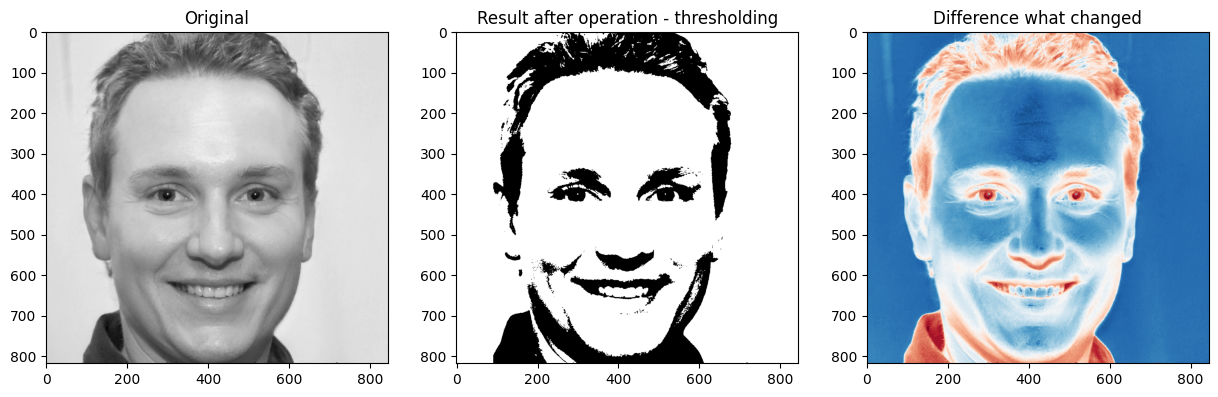

In [6]:
visualize_morphology(image, 'thresholding', binary)

In [11]:
# let's define a set of structural elements (SE)
kernels = [
    cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)),
    cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)),
    cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
]

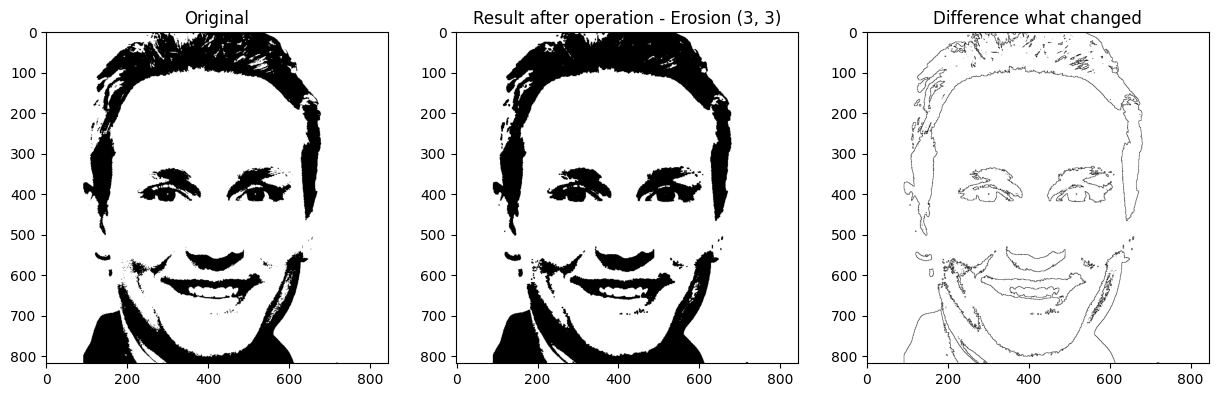

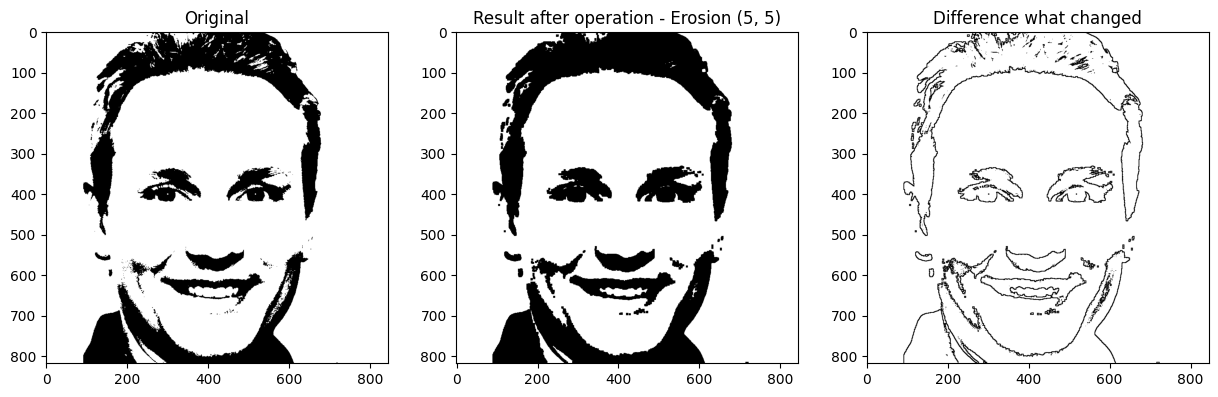

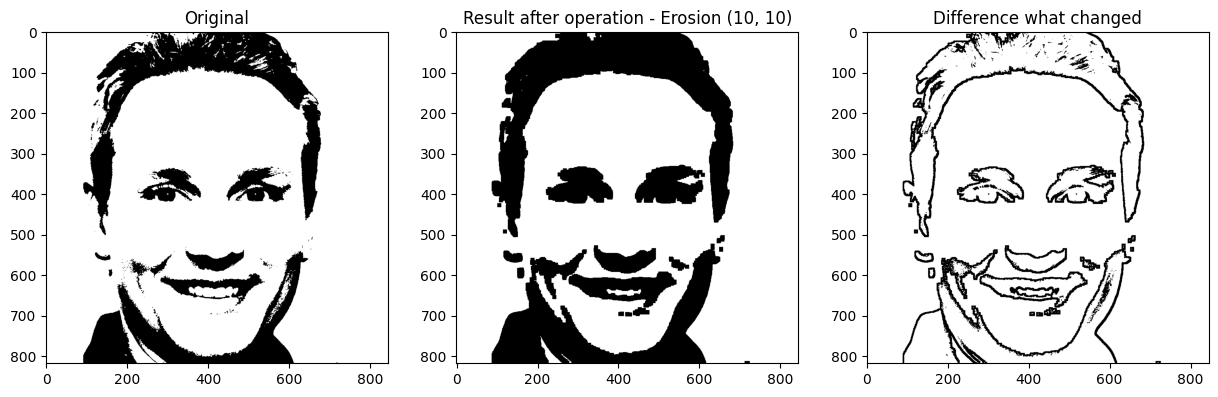

In [24]:
for kernel in kernels:
    eroded = cv2.erode(binary, kernel)
    visualize_morphology(binary, f'Erosion {kernel.shape}', eroded)

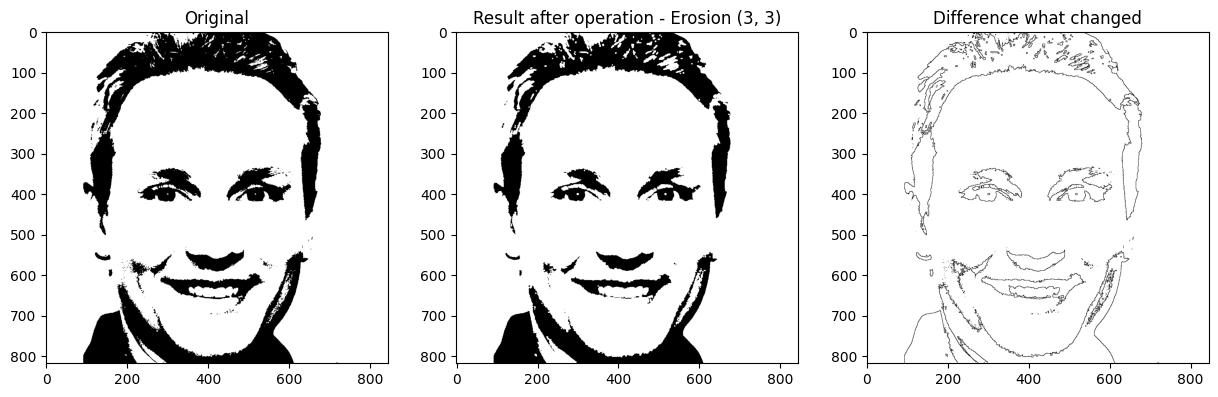

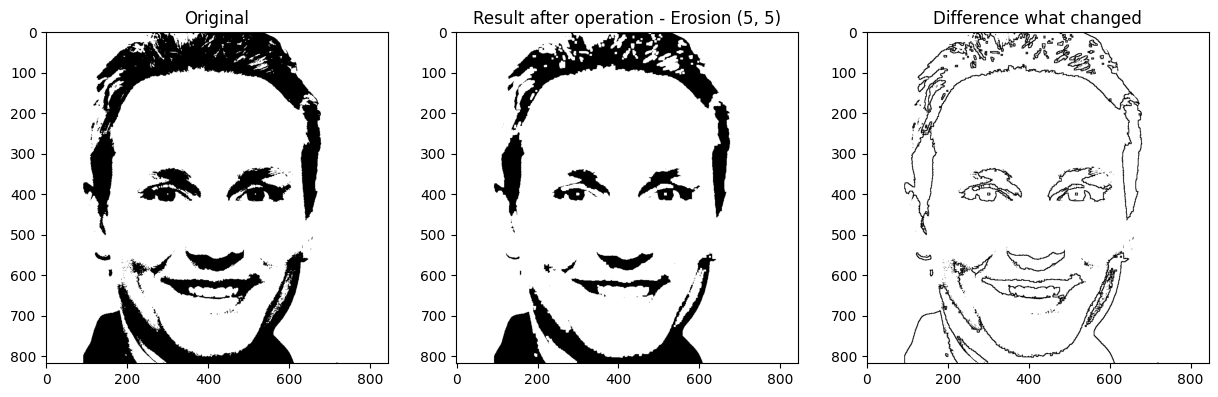

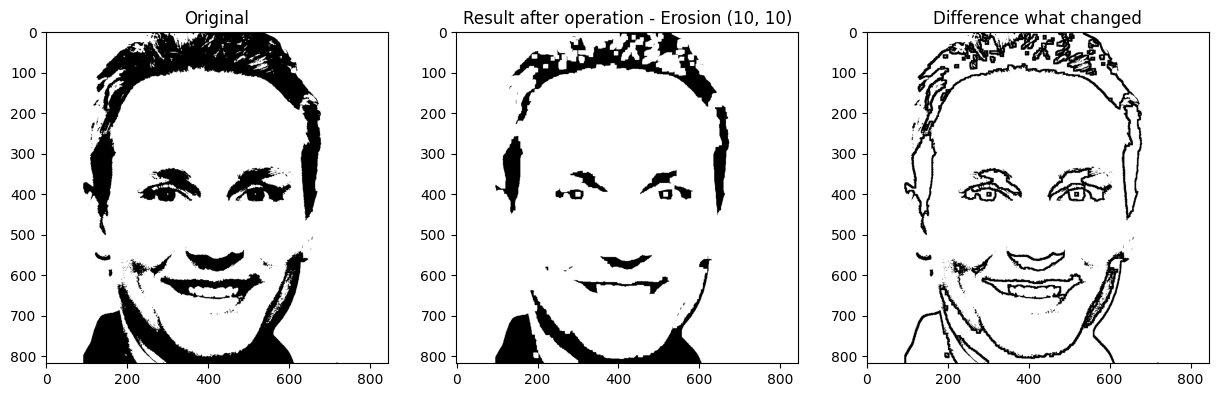

In [25]:
for kernel in kernels:
    eroded = cv2.dilate(binary, kernel)
    visualize_morphology(binary, f'Erosion {kernel.shape}', eroded)

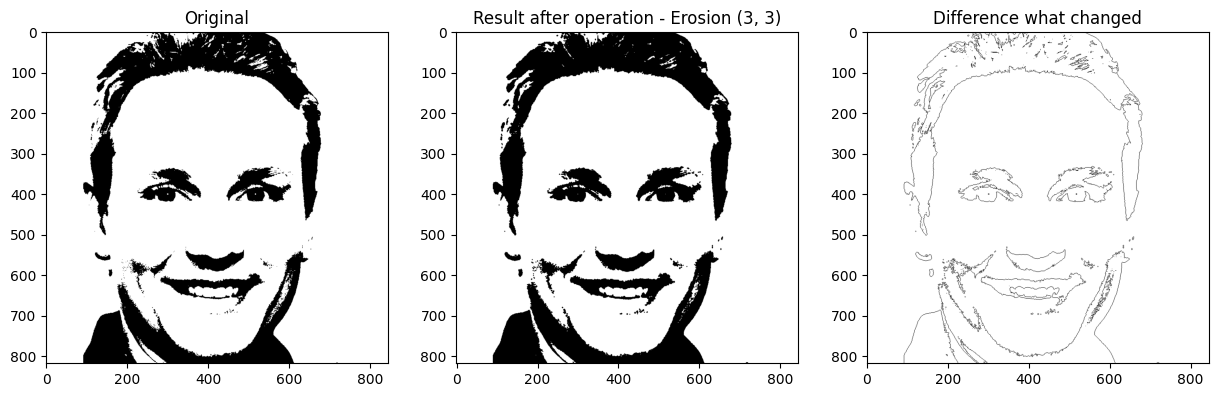

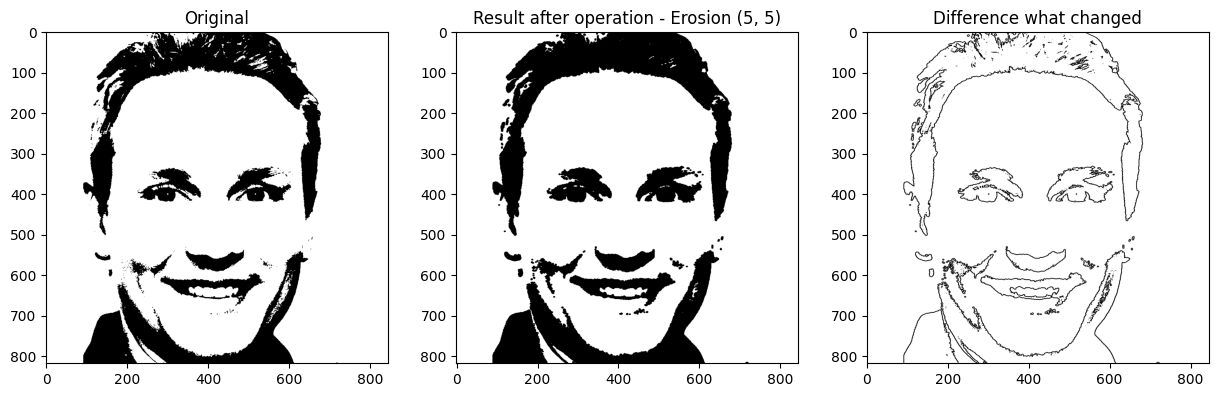

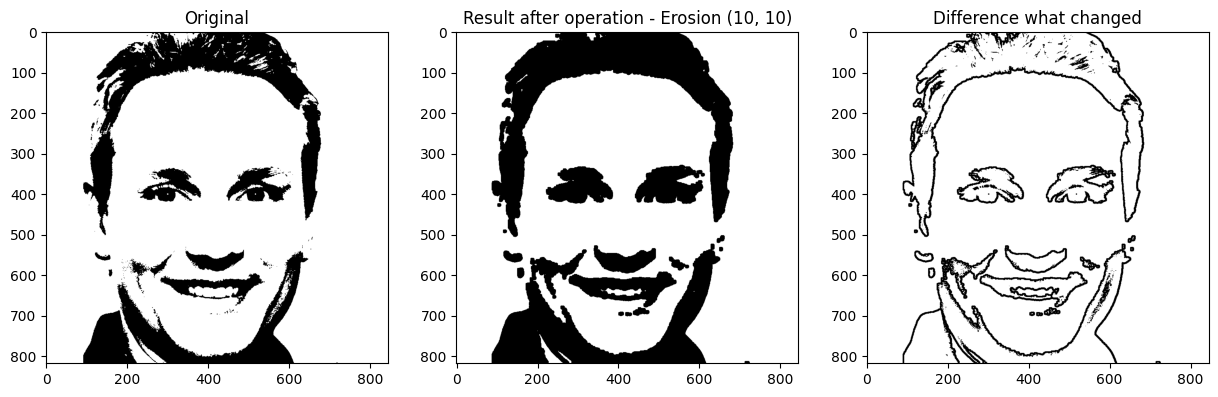

In [28]:
# Try different cernely types: ELIPS:
kernels = [
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)),
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)),
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
]
for kernel in kernels:
    eroded = cv2.erode(binary, kernel)
    visualize_morphology(binary, f'Erosion {kernel.shape}', eroded)

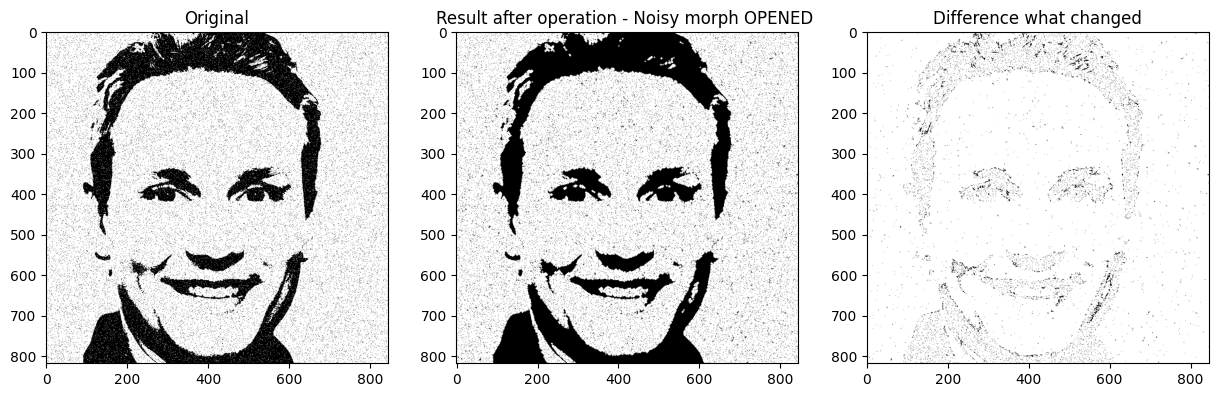

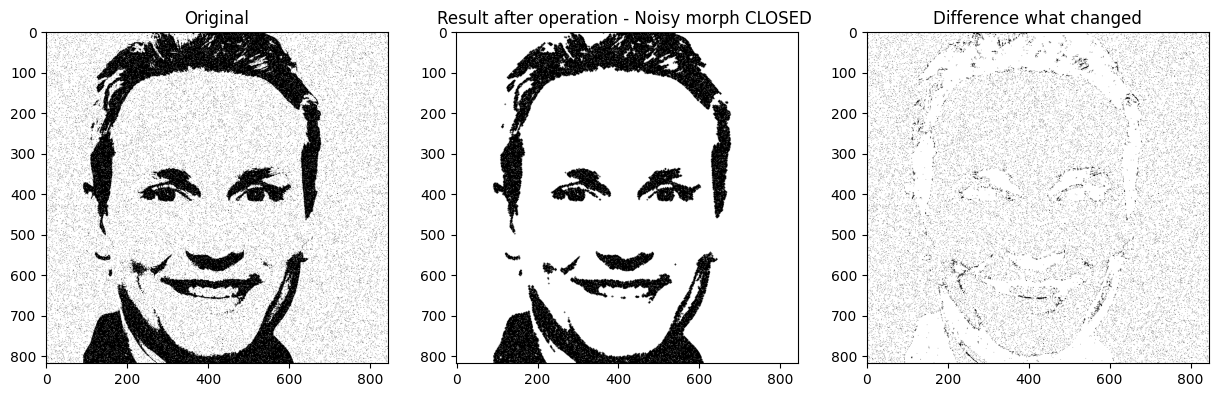

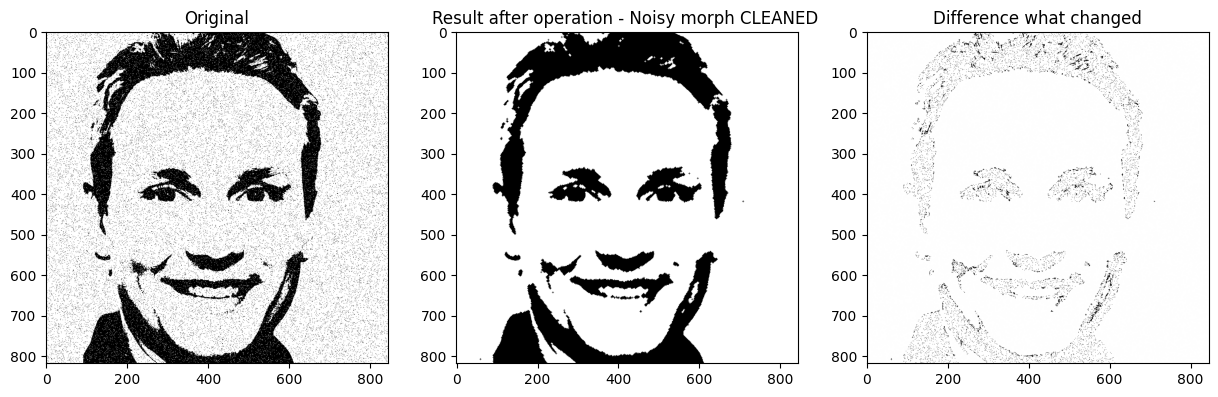

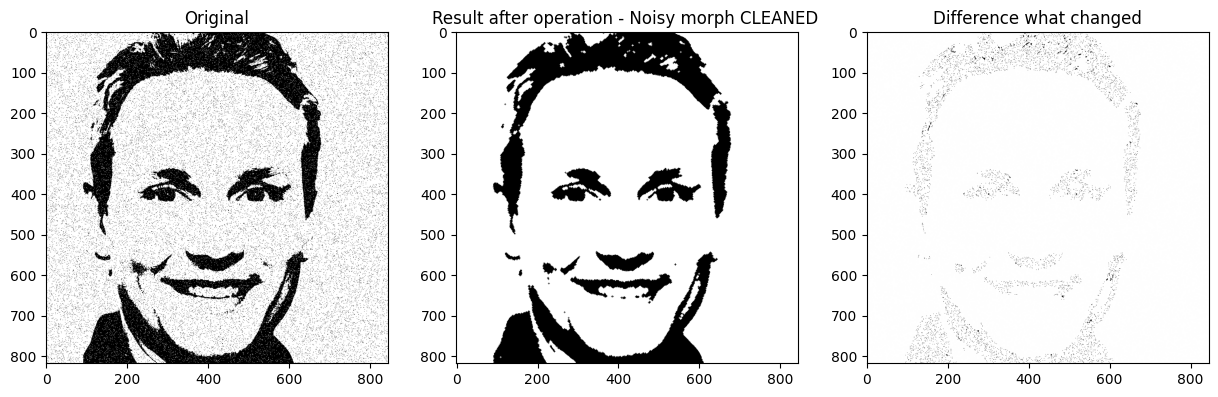

In [41]:
# Hour 2: Noise Removal Patterns

# Goal: Learn opening/closing through practical noise removal

# Quick Theory (10 min):
# Opening = Erosion then Dilation → removes small bright spots (salt noise)
# Closing = Dilation then Erosion → removes small dark spots (pepper noise)
# Why? Erosion removes small bright details, dilation restores large shapes

noisy = add_salt_and_pepper_noise(binary, 0.05, 0.05)

# experiment with opeening and closing
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))

# opening
# 1. apply opening to remove salt
opened = cv2.morphologyEx(noisy, cv2.MORPH_OPEN, kernel)
closed = cv2.morphologyEx(noisy, cv2.MORPH_CLOSE, kernel)
cleaned = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
cleaned2 = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)


visualize_morphology(noisy, 'Noisy morph OPENED ', opened)
visualize_morphology(noisy, 'Noisy morph CLOSED ', closed)
visualize_morphology(noisy, 'Noisy morph CLEANED ', cleaned)
visualize_morphology(noisy, 'Noisy morph CLEANED ', cleaned2)


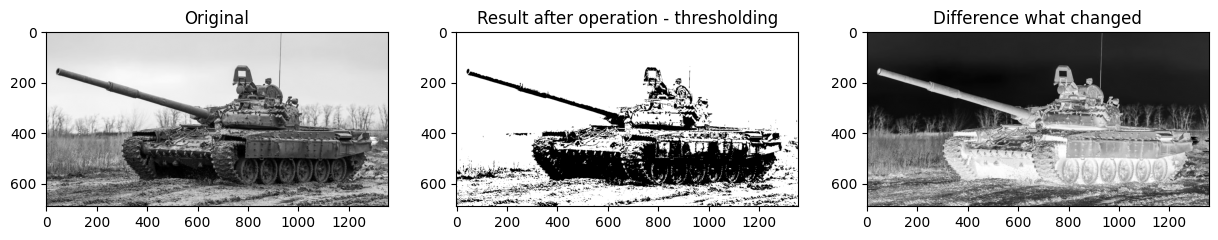

In [57]:
# Hour 3: Shape Analysis & Feature Extraction

# Goal: Use morphology to extract structural information

# Quick Theory (10 min):
# Boundary extraction: Original - Erosion
# Skeleton: Thinning operation (iterative erosion until 1-pixel width)
# Morphological gradient: Dilation - Erosion (edge detection)
image = cv2.imread('/Users/agerasymchuk/private_repo/cv_claude_course/cv_course/images/vehicle.png', cv2.IMREAD_GRAYSCALE)
_, vehicle_binary = cv2.threshold(image, 80, 255, cv2.THRESH_BINARY)
visualize_morphology(image, 'thresholding', vehicle_binary)

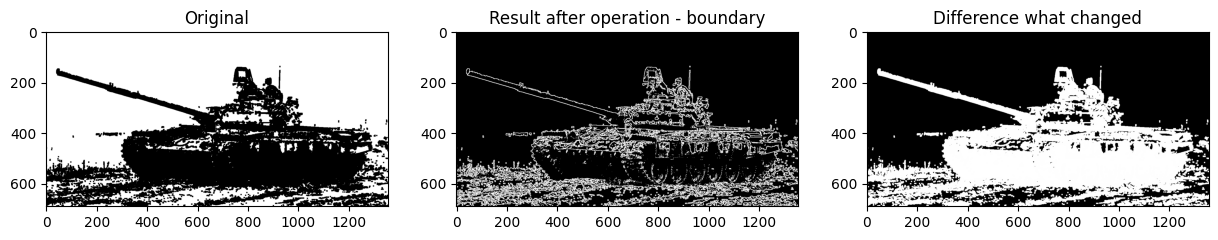

In [61]:
# morphological operation for shape analysis
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

# 1. extract bondaries
eroded = cv2.erode(vehicle_binary, kernel)
boundary = vehicle_binary - eroded
visualize_morphology(eroded, 'boundary', boundary)

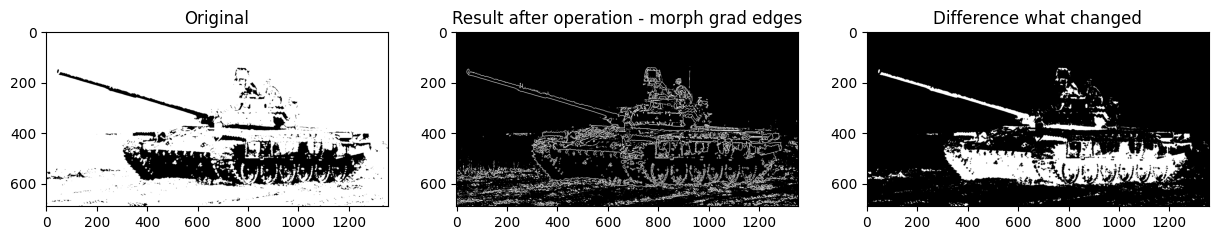

In [67]:
# 2. morphological gradient (edges)
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
dilated = cv2.dilate(vehicle_binary, kernel)
gradient = vehicle_binary - dilated
visualize_morphology(dilated, 'morph grad edges', gradient)

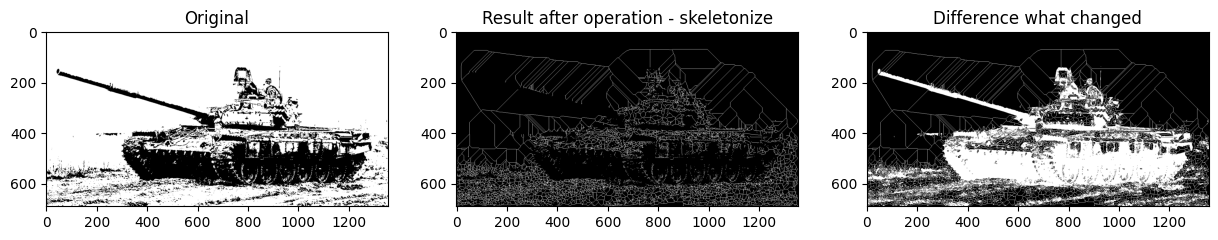

In [68]:
skeleton = skeletonize(vehicle_binary // 255) * 255
visualize_morphology(vehicle_binary, 'skeletonize', skeleton)

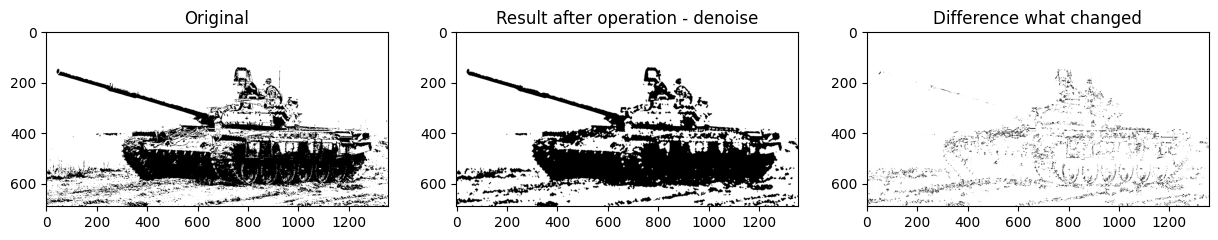

In [69]:
# let's improve it and check if ve can

# experiment with opeening and closing
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))

# opening
# 1. apply opening to remove salt
opened = cv2.morphologyEx(vehicle_binary, cv2.MORPH_OPEN, kernel)
cleaned = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

visualize_morphology(vehicle_binary, 'denoise', cleaned)


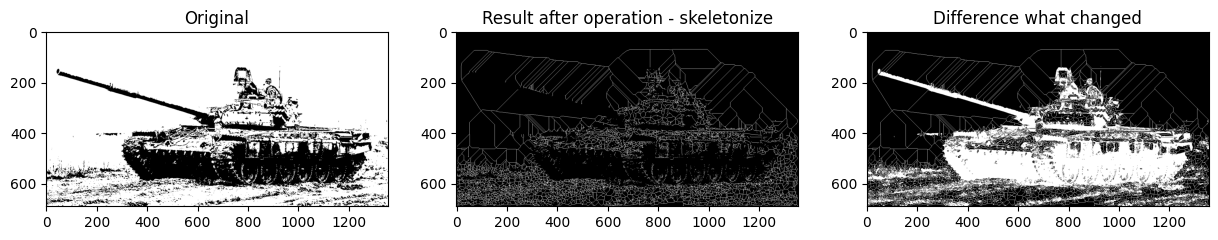

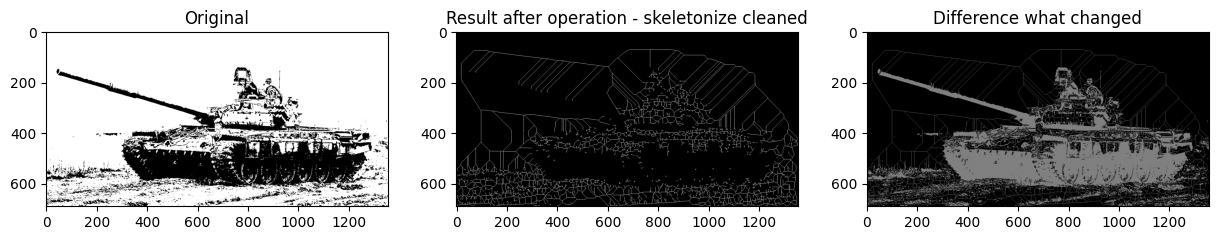

In [70]:
skeleton_cleaned = skeletonize(cleaned // 255) * 255
visualize_morphology(vehicle_binary, 'skeletonize', skeleton)
visualize_morphology(vehicle_binary, 'skeletonize cleaned', skeleton_cleaned)

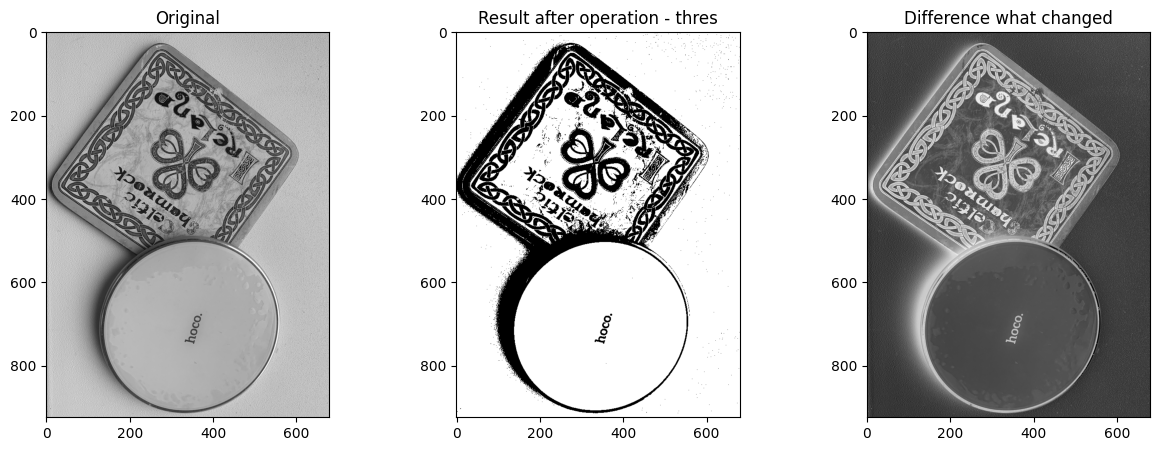

In [81]:
# try skeletoning simple object
simple = cv2.imread('/Users/agerasymchuk/private_repo/cv_claude_course/cv_course/images/geom_figures.png', cv2.IMREAD_GRAYSCALE)

# simple = cv2.resize(simple, (simple.shape[0]//4, simple.shape[1]//4), )
_, simple_binary = cv2.threshold(simple, 140, 255, cv2.THRESH_BINARY)
visualize_morphology(simple, 'thres', simple_binary)

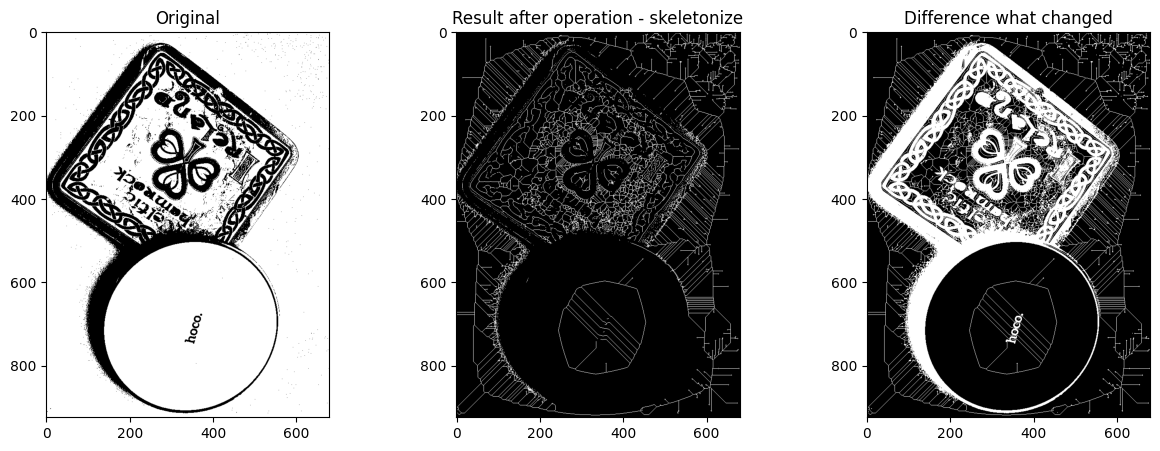

In [ ]:
skeleton_simple = skeletonize(simple_binary  // 255) * 255
visualize_morphology(simple_binary, 'skeletonize', skeleton_simple)

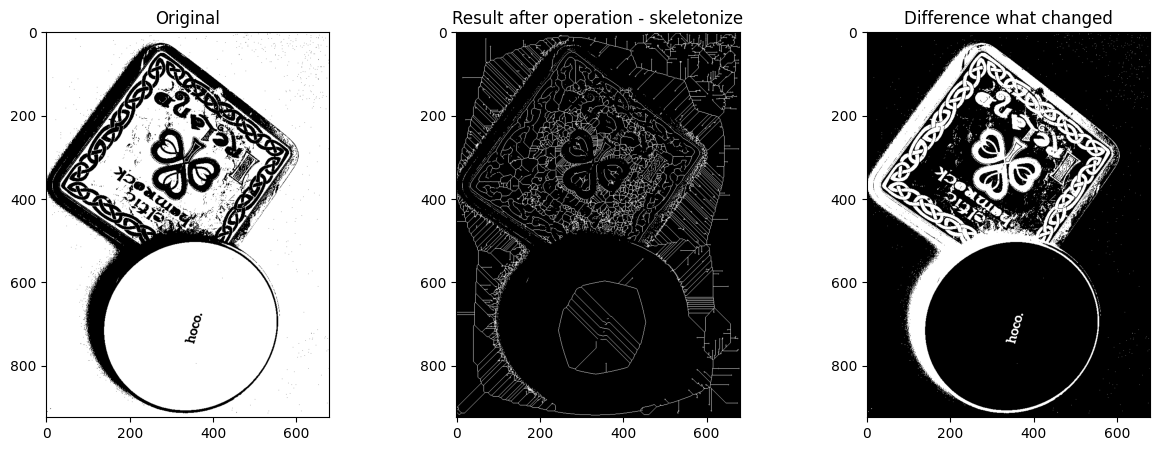

In [85]:
skeleton_simple = skeletonize(simple_binary > 0)
visualize_morphology(simple_binary, 'skeletonize', skeleton_simple)

In [90]:
# reconstruct a skeleton

skeleton_uint8 = (skeleton * 255).astype(np.uint8)
num_labels, labeled = cv2.connectedComponents(skeleton_uint8)

labeled.shape, skeleton.shape

((690, 1356), (690, 1356))

In [ ]:
result = analyze_connectivity(skeleton)

({'num_components': 1153,
  'total_pixels': 16370745,
  'num_branches': 63742,
  'num_endpoints': 0,
  'branch_points': array([[  68,  858],
         [  68,  859],
         [  68,  860],
         ...,
         [ 689, 1324],
         [ 689, 1354],
         [ 689, 1355]], shape=(63742, 2)),
  'endpoints': array([], shape=(0, 2), dtype=int64)},
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 1, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 1, 1]], shape=(690, 1356), dtype=int32))